# Úkol č. 2 - předzpracování dat a binární klasifikace (do 10. listopadu)

  * Cílem thoto úkolu je vyzkoušet si naučit prediktivní model pro binární klasifikaci.
  * Budete se muset vypořádat s příznaky, které jsou různých typů a které bude třeba nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * V Jupyter notebooku načtěte data ze souboru **data.csv**. Vhodným způsobem si je rozdělte na trénovací, testovací a případně i validační množinu (preferujeme ale použití cross-validation).
  * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména. Některé příznaky můžete také úplně zahodit.
  * Nějakým způsobem se vypořádejte s chybějícími hodnotami.
  * Následně si vyberte vhodný klasifikační model z přednášek. Najděte vhodné hyperparametry a určete jeho přesnost (accuracy) na trénovací množině. Také určete jeho přesnost na testovací/vaidační množině.
  * Načtěte vyhodnocovací data ze souboru **evaluation.csv**. Napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte **results.csv** soubor, ve kterém tyto predikce uložíte do dvou sloupců: ID, predikce přežití. Tento soubor nahrajte do repozitáře.

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * (až +4 body) Aplikujte všechny klasifikační modely z přednášek a určete (na základě přesnosti na validační množině), který je nejlepší. Přesnost tohoto nejlepšího modelu odhadněte pomocí testovací množiny. K predikcím na vyhodnocovacích datech využijte tento model.
  * (až +4 body) Zkuste použít nějaké (alespoň dvě) netriviální metody doplňování chybějících hodnot u věku. Zaměřte na vliv těchto metod na přesnost predikce výsledného modelu. K predikcím na vyhodnocovacích datech využijte ten přístup, který Vám vyjde jako nejlepší.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte nejen Jupyter Notebook, ale i _csv_ soubor(y) s predikcemi pro vyhodnocovací data.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. **První verze je ale důležitá a bude-li odbytá, budete za to penalizováni**

In [1]:
### odtud už je to Vaše

In [2]:
import numpy as np
import pandas as pd
import sklearn as skit
import matplotlib.pyplot as plt
import seaborn as sns

seed = 42

## Data cleanup
- females are 1's, males 0's
- missing data in the "embarked" column is replaced with S's for Southampton
- "embarked" values are converted to ints
- remove names, ticket numbers, cabin assignments and home/destination pairs from the dataset
    - these are either irrelevant to the regression algorithms or contain too many missing values

In [3]:
from numpy import nan

def cleanup(df):
    df.sex = df.sex.map(lambda x: 0 if x == "male" else 1)
    E = {"C": 0, "Q": 1, "S": 2, nan: 2}
    df.embarked = df.embarked.map(lambda x: E[x])

    df = df[df.fare.notnull()]
    del df["name"]
    del df["ticket"]
    del df["cabin"]
    del df["home.dest"]
    return df

raw = pd.read_csv("data.csv")
display(raw.isnull().sum(axis=0))
raw = cleanup(raw)

display(raw.count())
raw.head()

ID             0
survived       0
pclass         0
name           0
sex            0
age          201
sibsp          0
parch          0
ticket         0
fare           1
cabin        773
embarked       2
home.dest    435
dtype: int64

ID          999
survived    999
pclass      999
sex         999
age         798
sibsp       999
parch       999
fare        999
embarked    999
dtype: int64

,ID,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,1,3,1,22.0,0,0,7.7500,2
1,1,0,3,0,NaN,0,0,8.4583,1
2,2,1,1,1,19.0,1,0,91.0792,0
3,3,0,3,0,25.0,0,0,7.2250,0
4,4,0,3,0,NaN,0,0,7.7500,1


In [4]:
# test = raw.sample(frac=0.2)
# data = raw.loc[~raw.index.isin(test.index)]
data = raw
data.head()

,ID,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,1,3,1,22.0,0,0,7.7500,2
1,1,0,3,0,NaN,0,0,8.4583,1
2,2,1,1,1,19.0,1,0,91.0792,0
3,3,0,3,0,25.0,0,0,7.2250,0
4,4,0,3,0,NaN,0,0,7.7500,1


### Fill in missing ages
We simply take the median for each sex and fill it in.

In [5]:
def fill_age(df, sex):
    copy = df.copy()
    median = copy.age[copy.sex == sex].agg("median")
    copy["age"].fillna(median, inplace = True)
    return copy

def clean(df):
    df = fill_age(df, 0)
    df = fill_age(df, 1)
    return df

data = clean(data)
data.head()

,ID,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,1,3,1,22.0,0,0,7.7500,2
1,1,0,3,0,28.0,0,0,8.4583,1
2,2,1,1,1,19.0,1,0,91.0792,0
3,3,0,3,0,25.0,0,0,7.2250,0
4,4,0,3,0,28.0,0,0,7.7500,1


## Split to training&testing sets

In [6]:
from sklearn.model_selection import train_test_split

data_no_survived = data.drop(columns = ['survived'])
survived = data.survived
no_survived_train, no_survived_test, survived_train, survived_test = train_test_split(
    data_no_survived, survived, test_size = 0.2, random_state = seed
)

## Find suitable tree parameters

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid

tiny_N_train, tiny_N_test, tiny_S_train, tiny_S_test = train_test_split(
    no_survived_train, survived_train, test_size = 0.2, random_state = seed
)

param_grid = ParameterGrid({
    'criterion': ['entropy', 'gini'],
    'splitter': ['best', 'random'],
    'max_depth': range(2, 25),
    'presort': [True],
    'random_state': [seed],
})

train_predictions = []
test_predictions = []

for params in param_grid:
    dtc = DecisionTreeClassifier(**params)
    dtc.fit(tiny_N_train, tiny_S_train)
    train_predictions.append(accuracy_score(tiny_S_train, dtc.predict(tiny_N_train)))
    test_predictions.append(accuracy_score(tiny_S_test, dtc.predict(tiny_N_test)))

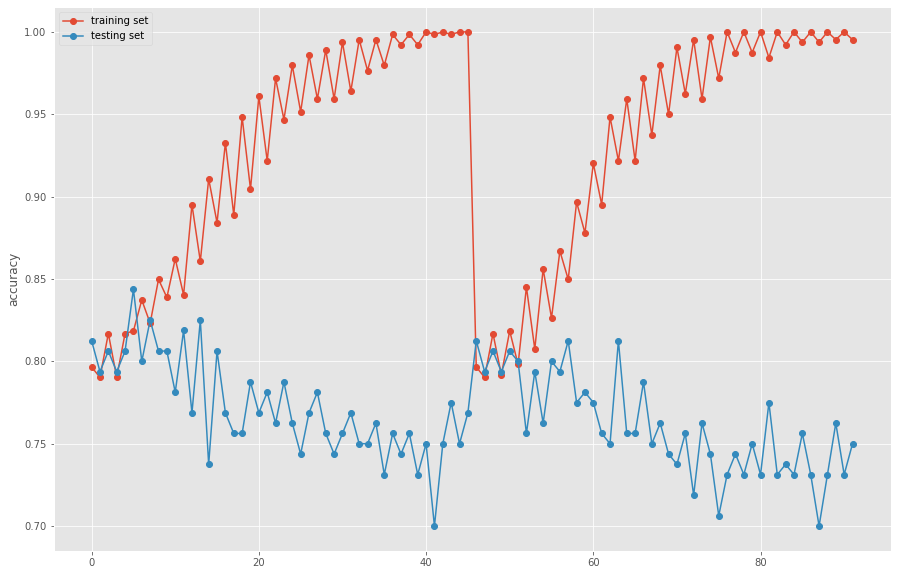

In [17]:
import matplotlib
%matplotlib inline 
matplotlib.style.use('ggplot')

f = plt.figure(figsize = (15, 10))
plt.plot(train_predictions, 'o-')
plt.plot(test_predictions, 'o-')
plt.ylabel("accuracy")
plt.legend(["training set", "testing set"])


In [20]:
display("optimal parameters for the testing set")
display(param_grid[np.argmax(test_predictions)])
display("optimal parameters for the training set")
display(param_grid[np.argmax(train_predictions)])


avg = (0.3 * np.array(train_predictions) + 0.7 * np.array(test_predictions)) / 2.0
display("optimal parameters for weighted average performance (70% testing set)")
bestAvgParams = param_grid[np.argmax(avg)]
display(bestAvgParams)
display("(index " + str(np.argmax(avg)) + ")")

'optimal parameters for the testing set'

{'splitter': 'random',
 'random_state': 42,
 'presort': True,
 'max_depth': 4,
 'criterion': 'entropy'}

'optimal parameters for the training set'

{'splitter': 'best',
 'random_state': 42,
 'presort': True,
 'max_depth': 22,
 'criterion': 'entropy'}

'optimal parameters for weighted average performance (70% testing set)'

{'splitter': 'random',
 'random_state': 42,
 'presort': True,
 'max_depth': 10,
 'criterion': 'gini'}

'(index 63)'

## Model evaluation

In [21]:
evl = pd.read_csv('evaluation.csv')
evl = cleanup(evl)
evl = clean(evl)
evl.head()

,ID,pclass,sex,age,sibsp,parch,fare,embarked
0,1000,1,0,13.0,2,2,262.3750,0
1,1001,3,0,36.0,0,0,7.4958,2
2,1002,3,0,31.0,0,0,7.7500,1
3,1003,3,0,31.0,0,0,7.2250,0
4,1004,3,0,36.0,0,0,9.5000,2


In [22]:
from sklearn.ensemble import RandomForestRegressor

dtc = DecisionTreeClassifier(**bestAvgParams)
dtc.